## <u>*Classsification Modelling for Area as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os

In [2]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm"],axis=1)

In [3]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

---

In [4]:
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df["numclaims"]=df["numclaims"].astype("object")

*Date preprocessing*

In [5]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [6]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat
14,1.66,0.484600,1,669.509999,9,2,1,1,5
16,1.51,0.993840,1,806.609999,9,2,0,5,3
17,0.76,0.539357,1,401.805451,3,2,1,2,3
40,1.89,0.654346,2,1811.709997,10,2,1,5,1
64,4.06,0.851472,1,5434.439987,10,1,1,5,2


*Define x and y*

In [7]:
x=df.drop("gender",axis=1)
y=df["gender"]

In [8]:
df["gender"].value_counts()

gender
0    2648
1    1976
Name: count, dtype: int64

*apply data balance method*

In [9]:
'''
from imblearn.over_sampling import SMOTE
smk=SMOTE(random_state=41)
x,y=smk.fit_resample(x,y)
'''

'\nfrom imblearn.over_sampling import SMOTE\nsmk=SMOTE(random_state=41)\nx,y=smk.fit_resample(x,y)\n'

*Splitting data into training and testing subsets*

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (3699, 8) and Y = (3699,) : 
Test data shape of X = (925, 8) and Y = (925,) : 


*Data Scaling*

In [11]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

---

## *Hyperparamers tunning*

* *Defining models and its parameters*

In [12]:
models = {
        
        "XGBRFClassifier": XGBRFClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        
}

search_spaces ={        
        "XGBRFClassifier":{
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),    # 0.3 is the default
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "subsample": hp.uniform("subsample",0.5,1.0),
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            'colsample_bytree': hp.uniform("colsample_bytree",0.5,1.0), 
            'colsample_bynode': hp.uniform("colsample_bynode",0.5,1.0),
            "reg_lambda": hp.quniform("reg_lambda",0,2,1),           #L2 regularization term on weights. Increasing this value will make model more conservative
            "reg_alpha": hp.quniform("reg_alpha",0,2,1)
            },
        "GradientBoostingClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "max_features": hp.choice("max_features",["sqrt", "log2"]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),
            "subsample": hp.uniform("subsample",0.8,1.0),
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0)
            },
        "RandomForestClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]), 
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
            "bootstrap": hp.choice("bootstrap",[True, False]),                                                                                                    
            "max_features": hp.choice("max_features",["sqrt", "log2"]),                                    
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "criterion": hp.choice("criterion",["gini", "entropy", "log_loss"])                    
        },
        "AdaBoostClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0)
        },
        "DecisionTreeClassifier": {
                    "criterion": hp.choice("criterion",["gini", "entropy", "log_loss"]),
                    'splitter': hp.choice("splitter",["best", "random"]),
                    "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
                    "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
                    "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
                    "max_features": hp.choice("max_features",["sqrt", "log2"])
        }                    
}

* *AdaBoostClassifier hyperparameter*

In [13]:
space=search_spaces["AdaBoostClassifier"]
def hyperparameter_tuning(space):
    clf = AdaBoostClassifier(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_AdaBoostClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_AdaBoostClassifier)    

100%|██████████| 10/10 [01:31<00:00,  9.15s/trial, best loss: -0.6342237501371466]
{'learning_rate': np.float64(0.039719340207795654), 'n_estimators': np.int64(2)}


* *GradientBoostingClassifier hyperparameter*

In [14]:
space=search_spaces["GradientBoostingClassifier"]
def hyperparameter_tuning(space):
    clf = GradientBoostingClassifier(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_GradientBoostingClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_GradientBoostingClassifier)    

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:18<00:00,  1.80s/trial, best loss: -0.5742091211644662]
{'learning_rate': np.float64(0.5065464452840154), 'max_depth': np.int64(2), 'max_features': np.int64(1), 'min_samples_leaf': np.float64(0.8175940796364162), 'min_samples_split': np.float64(0.9640939561957371), 'n_estimators': np.int64(0), 'subsample': np.float64(0.974437852886673)}


* *RandomForestClassifier hyperparameter*

In [15]:
space=search_spaces["RandomForestClassifier"]
def hyperparameter_tuning(space):
    clf = RandomForestClassifier(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_RandomForestClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_RandomForestClassifier)         

100%|██████████| 10/10 [00:31<00:00,  3.12s/trial, best loss: -0.5742091211644662]
{'bootstrap': np.int64(0), 'criterion': np.int64(0), 'max_depth': np.int64(3), 'max_features': np.int64(1), 'min_samples_leaf': np.float64(0.817659438410575), 'min_samples_split': np.float64(0.8030908990306427), 'n_estimators': np.int64(5)}


* *XGBRFClassifier hyperparameter*

In [16]:
space=search_spaces["XGBRFClassifier"]
def hyperparameter_tuning(space):
    clf = XGBRFClassifier(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_XGBRFClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_XGBRFClassifier)          

100%|██████████| 10/10 [00:41<00:00,  4.15s/trial, best loss: -0.6342186299967085]
{'colsample_bynode': np.float64(0.8714994123389928), 'colsample_bytree': np.float64(0.793153125539062), 'learning_rate': np.float64(0.691645029296458), 'max_depth': np.int64(2), 'n_estimators': np.int64(1), 'reg_alpha': np.float64(1.0), 'reg_lambda': np.float64(1.0), 'subsample': np.float64(0.5030310997926619)}


In [20]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestParams/gender_best_XGBRFClassifier.pkl","wb") as f:
    pickle.dump(best_XGBRFClassifier,f)

### *Final Result*

* *XGBRFClassifier model has the best and the lowest loss*

In [17]:
model = XGBRFClassifier(**best_XGBRFClassifier)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print(classification_report(y_test,predicted))


              precision    recall  f1-score   support

           0       0.59      0.89      0.71       524
           1       0.58      0.20      0.30       401

    accuracy                           0.59       925
   macro avg       0.59      0.54      0.50       925
weighted avg       0.59      0.59      0.53       925



In [21]:
unique_labels(y_test)
labels=unique_labels(y_test)
col_names=[f"predicted{label}"for label in labels ]
index_names=[f"Actual{label}"for label in labels ]
pd.DataFrame(confusion_matrix(y_test, predicted),columns=col_names,index=index_names)

,predicted0,predicted1
Actual0,465,59
Actual1,320,81


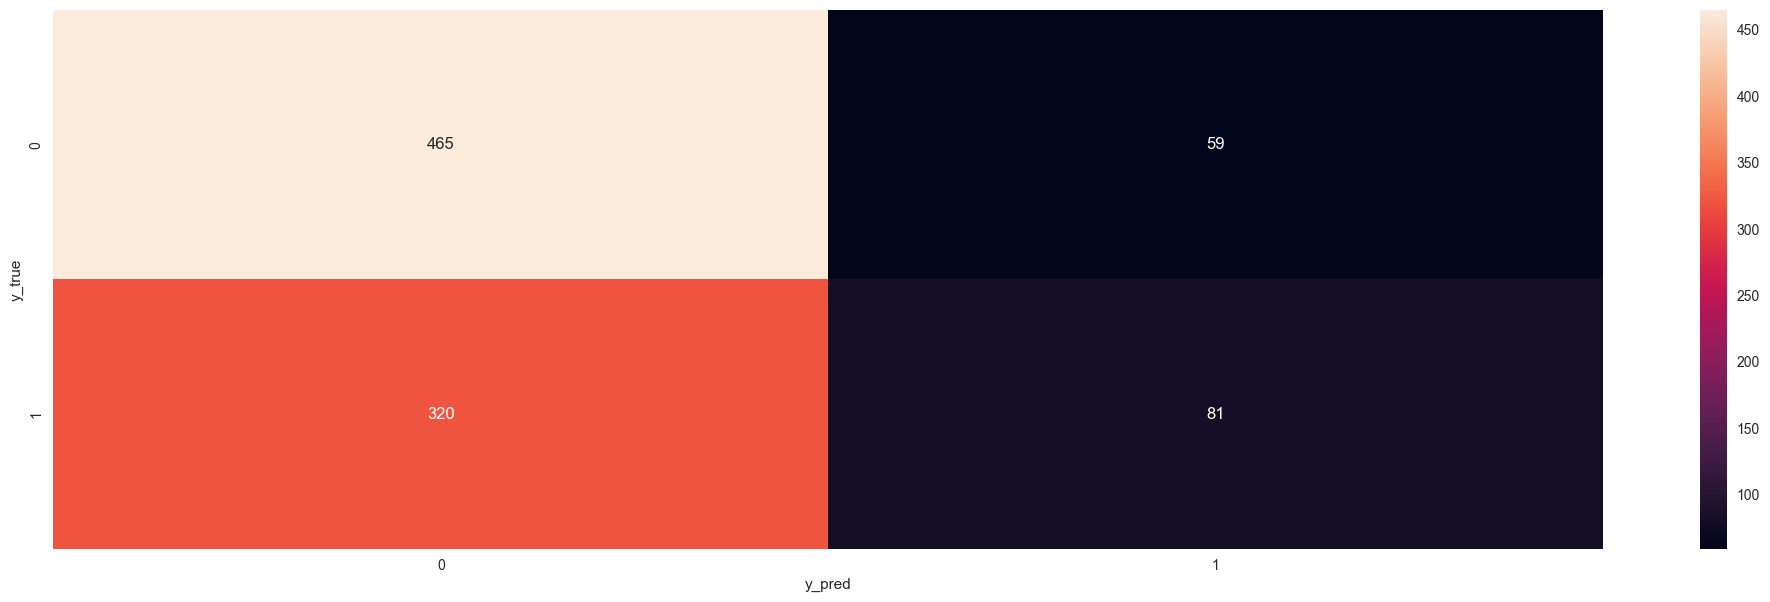

In [22]:
matplotlib.rcParams["figure.figsize"]=(25,7)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,linecolor = "red", fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true");

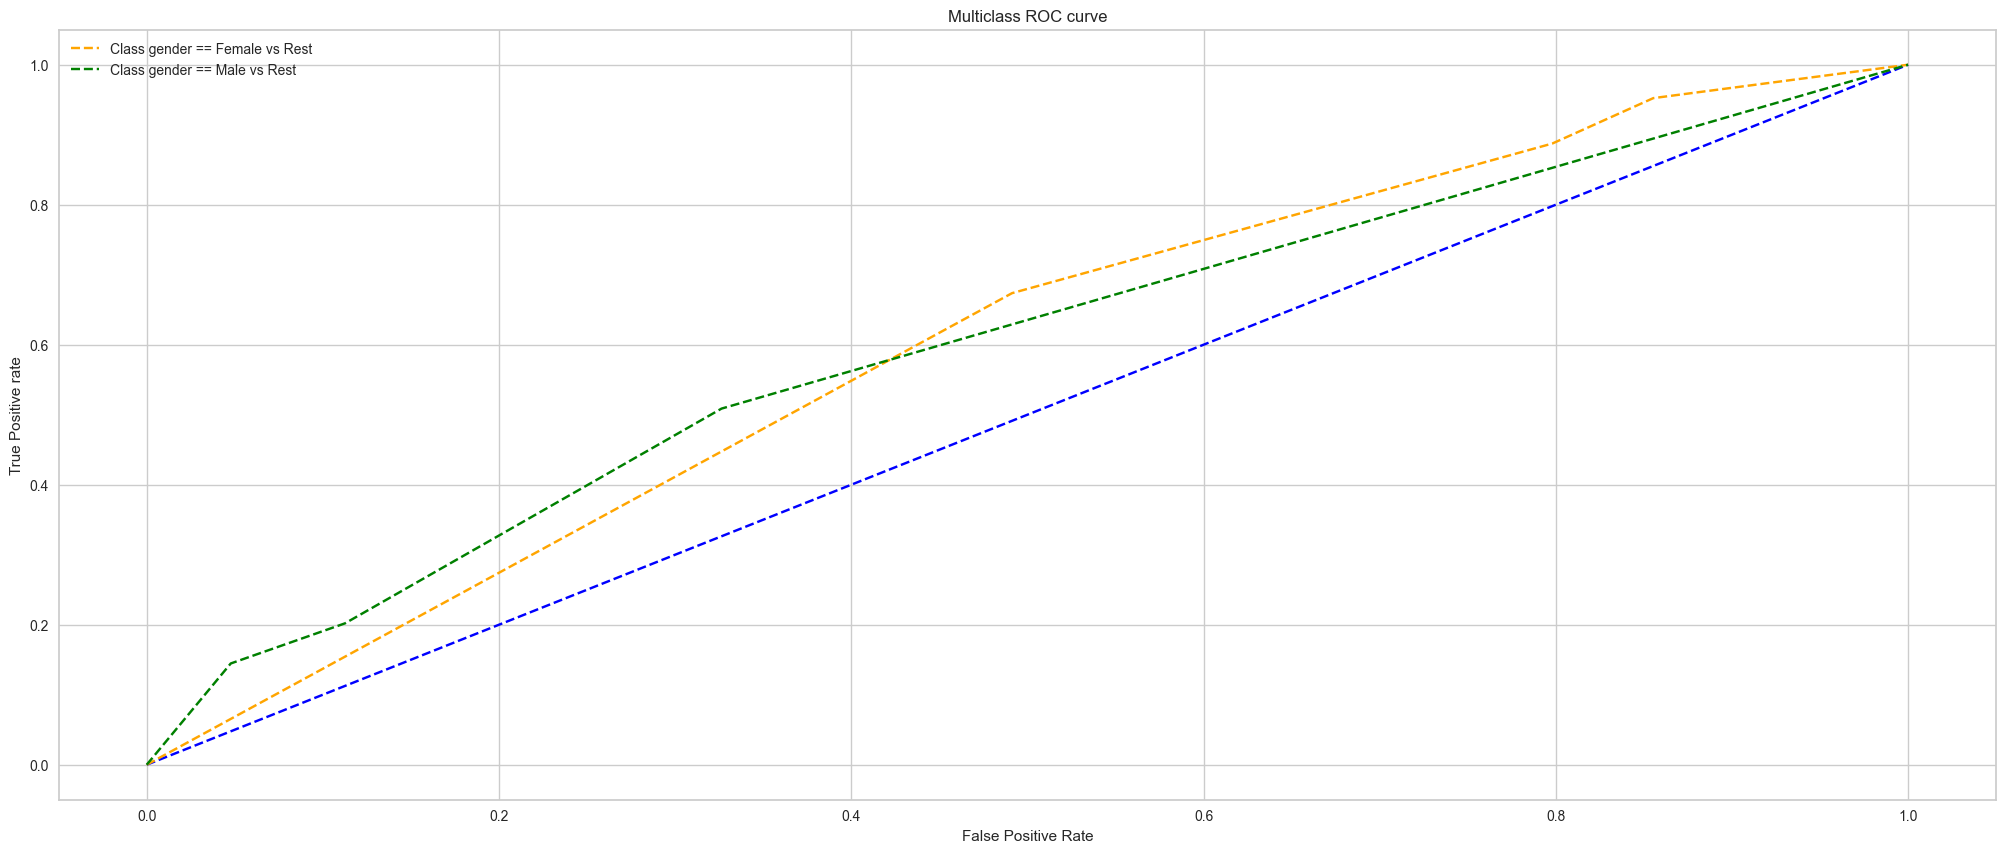

In [23]:
from sklearn.multiclass import OneVsRestClassifier
matplotlib.rcParams["figure.figsize"]=(25,10)
clf = OneVsRestClassifier( XGBRFClassifier(**best_XGBRFClassifier)).fit(x_train,y_train)


clf.fit(x_train, y_train)
pred = clf.predict(x_test)
pred_prob = clf.predict_proba(x_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2


random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class gender == Female vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class gender == Male vs Rest')


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/MulticlassROCGraphs/gender_MulticlassROCGraphs.png',dpi=500);  

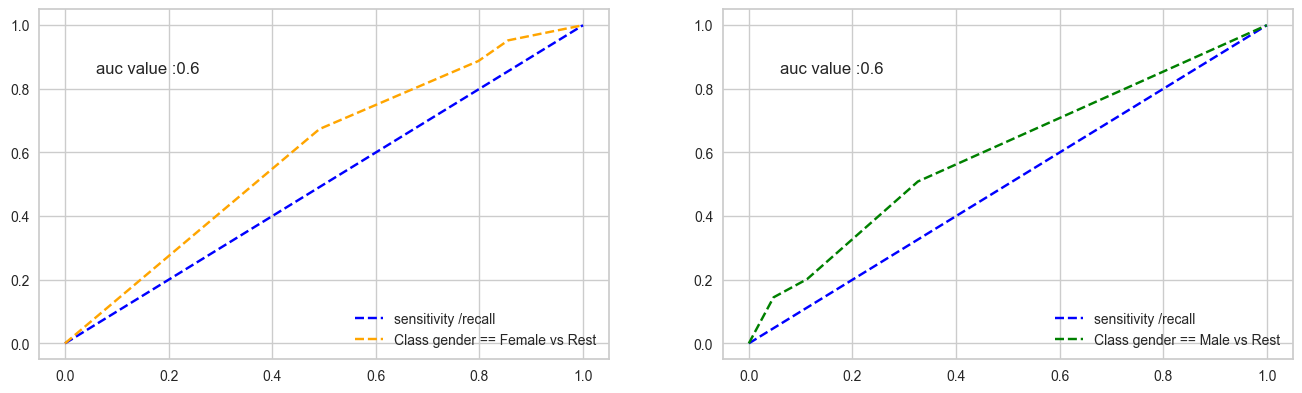

In [24]:
plt.subplot(231)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange')
plt.text(0.06,0.85, f'auc value :{round(auc(fpr[0], tpr[0]),2)}')
plt.legend(['sensitivity /recall','Class gender == Female vs Rest'])

plt.subplot(232)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.06,0.85, f'auc value :{round(auc(fpr[1], tpr[1]),2)}')
plt.legend(['sensitivity /recall','Class gender == Male vs Rest'])

plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/ROCcurveGraphs/gender_ROCcurveGraphs.png',dpi=500);

In [25]:
model.feature_names_in=x.columns
importance=pd.concat([pd.DataFrame(model.feature_names_in,columns=["feature_names"]),
           pd.DataFrame(model.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.444909
1,exposure,0.000000
2,numclaims,0.000000
3,claimcst0,0.000000
4,veh_body,0.555091
5,veh_age,0.000000
6,area,0.000000
7,agecat,0.000000


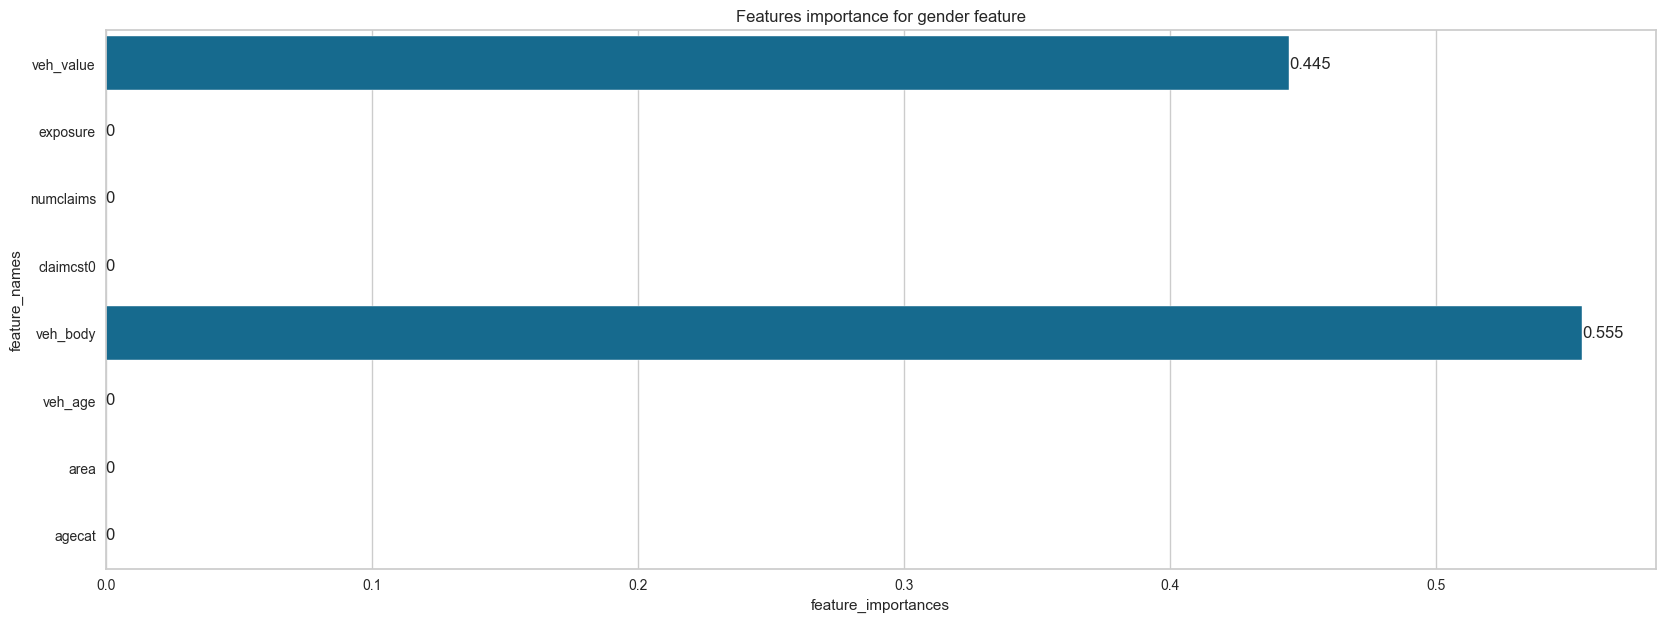

In [26]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for gender feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/gender_featureImportanc.png',dpi=500);

In [27]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/gender_prediction_model.pkl","wb") as f:
    pickle.dump(model,f)